### Import Libraries

In [63]:
import warnings
def warn(*arg, **kwargs):
    pass
warnings.warn = warn

In [64]:
seed = 2018
import math
import numpy as np
import edward as ed
ed.set_seed(seed)
import pandas as pd
import tensorflow as tf
np.random.seed(seed= seed)

from time import time
from edward.models import Categorical, Normal
from keras.utils import to_categorical
from plot_feature import plot_feature

import seaborn as sns
from scipy import stats
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import ticker
from sklearn.utils import resample
import scipy.special
from matplotlib.mlab import griddata
import matplotlib.tri as tri

RuntimeError: Seeding is not supported after initializing part of the graph. Please move set_seed to the beginning of your code.

In [ ]:
tf.set_random_seed(seed)

In [70]:
import dill
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from bokeh.layouts import gridplot
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected=True)

### Sklearn related modules

In [5]:
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.decomposition import PCA

### Plot related setups

In [6]:
# inspired by http://nipunbatra.github.io/2014/08/latexify/
%matplotlib inline

plt.style.use(['default'])
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 12,
    'font.size': 12, # was 10
    'legend.fontsize': 12, # was 10
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'text.usetex': True,
    'font.family': 'serif',
}
plt.rcParams.update(params)

### Import Data

In [7]:
## look data with pandas
train_file = "data/rupturemodel_train.txt"
val_file = "data/rupturemodel_xvalidate.txt"
test_file = "data/rupturemodel_test.txt"

df_train= pd.read_csv(train_file, sep=" ", header = None, dtype = np.float32)
df_val= pd.read_csv(val_file, sep=" ", header = None, dtype = np.float32)
df_test= pd.read_csv(test_file, sep=" ", header = None, dtype = np.float32)

features_name =  ['height', 'width', 'sxx', 'sxy', 'syy', 'sdrop', 'mud', 'dc', 'label']
df_train.columns = features_name
df_val.columns = features_name
df_test.columns = features_name

df_train_all = df_train.append(df_val)

### Data processing
We use StandardScaler preprocessing method of scikit. It standardizes features 
by removing the mean and scaling to unit variance

In [8]:
df = shuffle(df_train_all, random_state = seed)
df_test = shuffle(df_test, random_state = seed)

In [9]:
df.shape

(1600, 9)

### Class Balance

In [10]:
df.label.value_counts()

0.0    1041
1.0     559
Name: label, dtype: int64

In [11]:
df_major = df[df.label == 0]
df_minor = df[df.label == 1]

In [12]:
df_minor.shape[0]

559

In [13]:
df_minor_upsmapled = resample(df_minor, replace = True, n_samples = df_major.shape[0], random_state = seed)

In [14]:
df_minor_upsmapled = pd.concat([df_minor_upsmapled, df_major])

In [15]:
df_minor_upsmapled.label.value_counts()

0.0    1041
1.0    1041
Name: label, dtype: int64

### Analysis

In [16]:
features =['height', 'width', 'sxx', 'sxy', 'syy', 'sdrop', 'mud', 'dc']

/Users/sabber/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



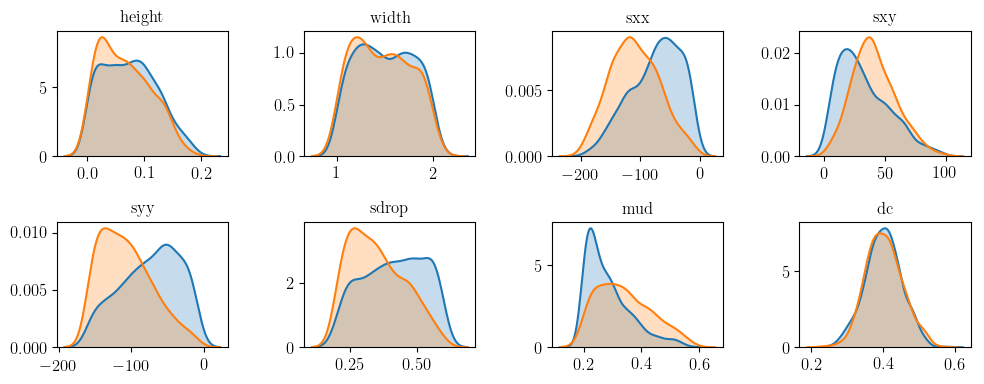

In [17]:
plt.figure(figsize=(10, 4))

for i, feature in enumerate(features):
    plt.subplot(2, 4, i + 1)
    sns.kdeplot(df[feature][df.label == 0], shade= True, legend=False)
    sns.kdeplot(df[feature][df.label == 1], shade= True, legend=False)
    plt.title(feature)
    
plt.tight_layout()
plt.show()

### Fetaure Scaling

In [18]:
mms = StandardScaler()
train_scale = mms.fit(df.drop('label', axis=1))

xtrain = train_scale.transform(df.drop('label', axis=1))
ytrain =  np.array(df['label'].values)
ytrain = ytrain.reshape(ytrain.shape[0], 1)

xtest = train_scale.transform(df_test.drop('label', axis=1))
ytest = np.array(df_test['label'].values)
ytest = ytest.reshape(ytest.shape[0], 1)

In [19]:
np.shape(xtrain)

(1600, 8)

### Feature analysis

/Users/sabber/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



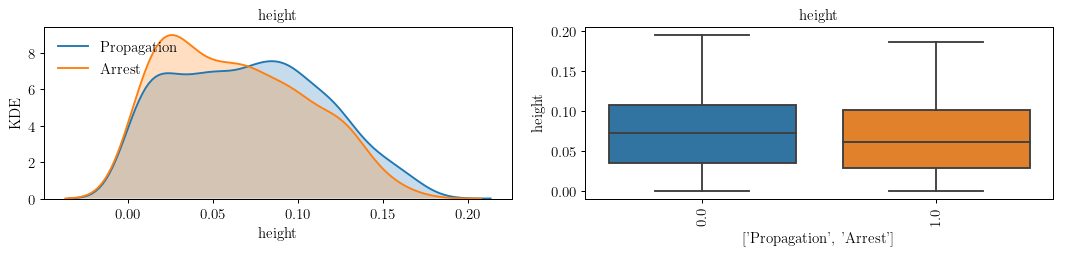

In [20]:
plot_feature(df, 'height', True, False)

/Users/sabber/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



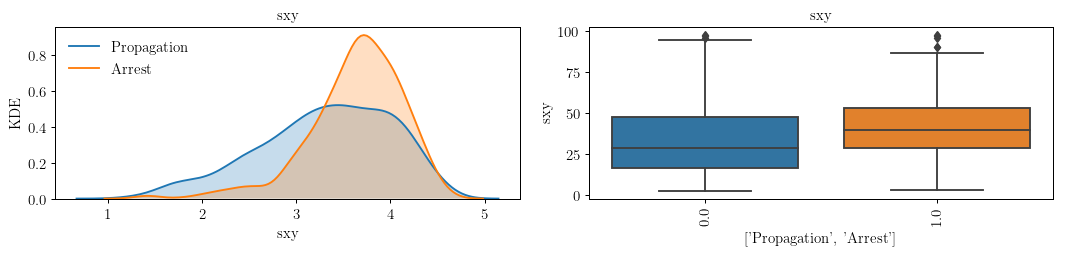

In [21]:
plot_feature(df, 'sxy', True, False)

/Users/sabber/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



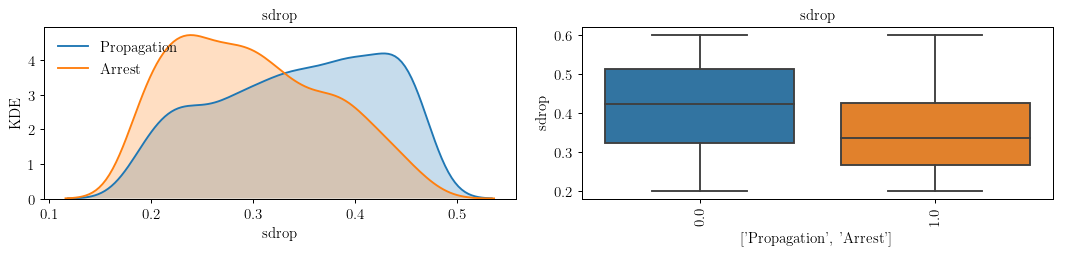

In [22]:
plot_feature(df, 'sdrop', True, False)

### Parallel coordinate plot

In [23]:
df = pd.DataFrame(xtrain, columns= ['height', 'width', 'sxx', 'sxy', 'syy', 'sdrop', 'mud', 'dc'])

In [24]:
df['label'] = ytrain

In [25]:
data = [
    go.Parcoords(
        line = dict(color = df['label'],
                   colorscale = 'Jet',
                   showscale = True,
                   reversescale = True,
                   cmin = 0,
                   cmax = 1),
        
        dimensions = list([
            dict(label = 'Height', values = df['height']),
            
            dict(label = 'Width', values = df['width']),
            
            dict(label = 'sxx', values = df['sxx']),
            
            dict(label = 'sxy', values = df['sxy']),
            
            dict(label = 'syy', values = df['syy']),
            
            dict(label = 'sdrop', values = df['sdrop']),
            
            dict(label = 'mud', values = df['mud']),
            
            dict(label = 'dc', values = df['dc']),
            
            dict(tickvals = [0, 1],
                 ticktext = ['Propagation','Arrest'],
                 label = 'Target', values = df['label'])
        ])
    )
]

iplot(data)

### Determine linear coeficient

In [26]:
from sklearn.linear_model import Lasso, Ridge

In [23]:
#A helper method for pretty-printing linear models
def pretty_print_linear(coefs, names = None, sort = False):
    if names == None:
        names = ["X%s" % x for x in range(len(coefs))]
    lst = zip(coefs, names)
    if sort:
        lst = sorted(lst,  key = lambda x:-np.abs(x[0]))
    return " + ".join("%s * %s" % (np.round(coef, 3), name)
                                   for coef, name in lst)

In [24]:
lasso = Lasso(alpha=0.0005)
lasso.fit(xtrain, ytrain)
print("Lasso model: ", pretty_print_linear(lasso.coef_, features, sort = False))

ridge = Ridge(alpha=10)
ridge.fit(xtrain, ytrain)
print("Ridge model: ", pretty_print_linear(ridge.coef_, features, sort = False))

Lasso model:  -0.032 * height + -0.018 * width + -0.085 * sxx + -0.002 * sxy + -0.098 * syy + -0.049 * sdrop + 0.111 * mud + 0.008 * dc
Ridge model:  [-0.032 -0.019 -0.086 -0.008 -0.103 -0.046  0.111  0.008] * height


## Model setup

### 1. Hyperparameters 

In [27]:
## Hyperparameters
N = np.shape(xtrain)[0]
in_size = np.shape(xtrain)[1]
out_size = 1
l1 = 12 # Number of neurons in the first layer
BATCH_SIZE = 32

### 2. Define neural network

In [28]:
def neural_network(X, W_0, W_1, b_0, b_1):
    hidden1 = tf.nn.relu(tf.matmul(X, W_0) + b_0)
    output = tf.nn.sigmoid(tf.matmul(hidden1, W_1) + b_1)
    return output

In [29]:

with tf.name_scope('model_prior'):
    
    W_0 = Normal(loc = tf.zeros([in_size, l1], name="weights/loc_w_0"), 
                 scale = tf.ones([in_size, l1], name="weights/scale_w_0"),
                 name  = 'weight_w_0')
    W_1 = Normal(loc=tf.zeros([l1, out_size], name="weights/loc_w_1"), 
                 scale=tf.ones([l1, out_size], name="weights/scale_w_1"),
                 name  = 'weight_w_1')
    b_0 = Normal(loc=tf.zeros(l1, name="weights/loc_b_0"), 
                 scale=tf.ones(l1, name="weights/scale_b_0"),
                 name  = 'weight_b_0')
    b_1 = Normal(loc=tf.zeros(out_size, name="weights/loc_b_1"),
                 scale=tf.ones(out_size, name="weights/scale_b_1"),
                 name  = 'weight_b_1')
    
    X = tf.placeholder(tf.float32, shape = (None, in_size)) 
    y = Normal(loc = neural_network(X, W_0, W_1, b_0, b_1), scale = 1.0)

### 3. Model Prior parameter distributions

In [30]:
with tf.name_scope('posterior'):
    qW_0 = Normal(loc = tf.Variable(tf.random_normal([in_size, l1]), name = "weights/loc_qw_0" ), 
                  scale = tf.Variable(tf.random_normal([in_size, l1]), name = "weights/scale_qw_0"),
                  name = "weight_qw_0")
    
    qW_1 = Normal(loc = tf.Variable(tf.random_normal([l1, out_size]), name = "weights/loc_qw_1" ), 
                  scale = tf.Variable(tf.random_normal([l1, out_size]), name = "weights/loc_qw_1" ),
                  name = "weight_qw_1")
    
    qb_0 = Normal(loc = tf.Variable(tf.random_normal([l1]), name = "weights/loc_qb_0" ), 
                scale = tf.Variable(tf.random_normal([l1]), name = "weights/loc_qb_0" ),
                name = "weight_qb_0")
    qb_1 = Normal(loc = tf.Variable(tf.random_normal([out_size]), name = "weights/loc_qb_1" ), 
                scale = tf.Variable(tf.random_normal([out_size]), name = "weights/loc_qb_1" ),
                name = "weight_qb_1")

### Model posterior weights

In [31]:
with tf.name_scope('posterior'):
    qW_0 = Normal(loc = tf.Variable(tf.random_normal([in_size, l1]), name = "weights/loc_qw_0" ), 
                  scale = tf.Variable(tf.random_normal([in_size, l1]), name = "weights/scale_qw_0"),
                  name = "weight_qw_0")
    
    qW_1 = Normal(loc = tf.Variable(tf.random_normal([l1, out_size]), name = "weights/loc_qw_1" ), 
                  scale = tf.Variable(tf.random_normal([l1, out_size]), name = "weights/loc_qw_1" ),
                  name = "weight_qw_1")
    
    qb_0 = Normal(loc = tf.Variable(tf.random_normal([l1]), name = "weights/loc_qb_0" ), 
                scale = tf.Variable(tf.random_normal([l1]), name = "weights/loc_qb_0" ),
                name = "weight_qb_0")
    qb_1 = Normal(loc = tf.Variable(tf.random_normal([out_size]), name = "weights/loc_qb_1" ), 
                scale = tf.Variable(tf.random_normal([out_size]), name = "weights/loc_qb_1" ),
                name = "weight_qb_1")

## Inference

In [32]:
with tf.name_scope("inference"):
    
    inference = ed.KLqp({W_0: qW_0, b_0: qb_0,
                         W_1: qW_1, b_1: qb_1}, 
                        data={X: xtrain, 
                              y: ytrain})

    global_step = tf.Variable(0, trainable = True, name = "global_step")
    initial_learning_rate = tf.Variable(0.001, trainable = True, name = "initial_learning_rate")

    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step,
                                               10000, 0.3, staircase = True, name = 'learning_rate')

    optimizer = tf.train.AdamOptimizer(learning_rate)

    inference.run(n_iter = 5000, optimizer = optimizer, global_step = global_step, logdir = r'./log')

5000/5000 [100%] ██████████████████████████████ Elapsed: 10s | Loss: 1660.324


## Sampling 

In [41]:
%%time

n_samples = 5000

qW_0_samples = qW_0.sample(sample_shape = n_samples, seed = 2018)
qW_1_samples = qW_1.sample(sample_shape = n_samples, seed = 2018)
qb_0_samples = qb_0.sample(sample_shape = n_samples, seed = 2018)
qb_1_samples = qb_1.sample(sample_shape = n_samples, seed = 2018)

print("Preparing to sample...")

t0 = time()
samplenodes = tf.stack([neural_network(X, qW_0_samples[i], qW_1_samples[i],
                                       qb_0_samples[i], qb_1_samples[i]) 
                        for i in range(n_samples)], axis=0)

print("Sampling...")
samplepredictions = samplenodes.eval(feed_dict={X: xtest})
predictions_samp = samplepredictions[:, :, 0]

CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 26.9 µs
Preparing to sample...
Took 79 secs.
Sampling...
Took 234 secs.


In [78]:
samplenodes.eval()

InvalidArgumentError: You must feed a value for placeholder tensor 'model_prior/Placeholder' with dtype float and shape [?,8]
	 [[Node: model_prior/Placeholder = Placeholder[dtype=DT_FLOAT, shape=[?,8], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'model_prior/Placeholder', defined at:
  File "/Users/sabber/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/sabber/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/sabber/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/sabber/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/sabber/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/Users/sabber/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/Users/sabber/anaconda3/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/Users/sabber/anaconda3/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/Users/sabber/anaconda3/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/Users/sabber/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/Users/sabber/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/sabber/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/Users/sabber/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/sabber/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/Users/sabber/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/sabber/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/sabber/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/sabber/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/sabber/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/sabber/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/sabber/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Users/sabber/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/sabber/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/sabber/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-29-c46e8bd2501e>", line 17, in <module>
    X = tf.placeholder(tf.float32, shape = (None, in_size))
  File "/Users/sabber/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1777, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/Users/sabber/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 4521, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/Users/sabber/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/sabber/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3290, in create_op
    op_def=op_def)
  File "/Users/sabber/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1654, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'model_prior/Placeholder' with dtype float and shape [?,8]
	 [[Node: model_prior/Placeholder = Placeholder[dtype=DT_FLOAT, shape=[?,8], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


### Save samples

In [74]:
import pickle
weights = dict()
weights['qW_0_samples'] = qW_0_samples
weights['qW_1_samples'] = qW_1_samples
weights['qb_0_samples'] = qb_0_samples
weights['qb_1_samples'] = qb_1_samples

In [76]:
weights

{'qW_0_samples': <tf.Tensor 'posterior_1/weight_qw_0/sample_2/Reshape:0' shape=(5000, 8, 12) dtype=float32>,
 'qW_1_samples': <tf.Tensor 'posterior_1/weight_qw_1/sample_2/Reshape:0' shape=(5000, 12, 1) dtype=float32>,
 'qb_0_samples': <tf.Tensor 'posterior_1/weight_qb_0/sample_2/Reshape:0' shape=(5000, 12) dtype=float32>,
 'qb_1_samples': <tf.Tensor 'posterior_1/weight_qb_1/sample_2/Reshape:0' shape=(5000, 1) dtype=float32>}

In [75]:
with open('model_weights.pkl', 'wb') as file:
    pickle.dump(weights, file, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'wb') as handle:
#     pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

TypeError: can't pickle _thread.RLock objects

In [69]:
# !pip install dill

### Prior and posterior weight vizualization

In [42]:
### prior weights
prior_weights = W_0.eval(), W_1.eval(), b_0.eval(), b_1.eval()

### Posterior mean weights
post_weights_mean = qW_0_samples.eval().mean(axis = 0), qW_1_samples.eval().mean(axis = 0),\
               qb_0_samples.eval().mean(axis = 0), qb_1_samples.eval().mean(axis = 0)

In [43]:
### Posterior standard deviation of weights
post_weights_std = qW_0_samples.eval().std(axis = 0), qW_1_samples.eval().std(axis = 0),\
               qb_0_samples.eval().std(axis = 0), qb_1_samples.eval().std(axis = 0)

In [44]:
np.shape(prior_weights[0])

(8, 12)

In [45]:
np.shape(qW_0_samples.eval())

(5000, 8, 12)

In [46]:
wgt = ['w$^0$', 'w$^1$', 'b$^0$', 'b$^1$']
lbl = ['a', 'b', 'c', 'd']
def plot_weight_distribution(prior = True):

    plt.figure(figsize=(8, 6))
    
    for i in range(len(prior_weights)):
        plt.subplot(2, 2, i+1)
        if i == 3:
            plt.plot(prior_weights[i].reshape(-1), "ro", label = 'Prior')
            plt.plot(post_weights_mean[i].reshape(-1), "bo", label = 'Prior')
        else:
            sns.kdeplot(prior_weights[i].reshape(-1), shade = True, color = "r", label = 'Prior')
            sns.kdeplot(post_weights_mean[i].reshape(-1), shade = True, color = "b", label = 'Posterior')

        plt.title('(' + lbl[i] + ') ' + wgt[i])
        plt.ylabel('Density')
        plt.xlabel('Weight')
        
    plt.legend(frameon=False)
    plt.tight_layout()
#     plt.show()
    plt.savefig('../paper/figures/posterior_weight.png')

/Users/sabber/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



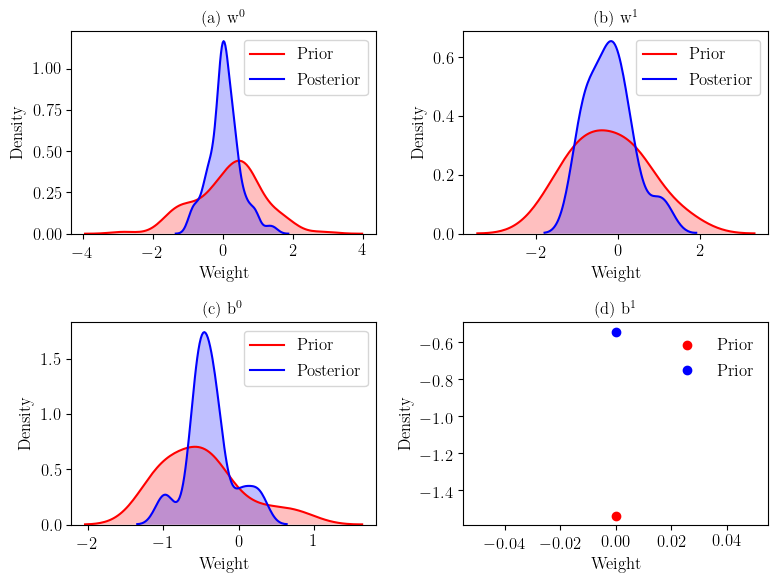

In [47]:
plot_weight_distribution()

### Statistics on prior and posterior weigth distribution

In [48]:
for i, wt in enumerate(wgt):
    print(wt)
    print(np.mean(prior_weights[i].reshape(-1)))
    print(np.mean(post_weights_mean[i].reshape(-1)))
    print(np.std(prior_weights[i].reshape(-1)))
    print(np.std(post_weights_mean[i].reshape(-1)))

w$^0$
0.17477335
0.055613864
0.9661317
0.4393119
w$^1$
-0.23921625
-0.20891495
0.8806865
0.55072397
b$^0$
-0.4861544
-0.3818799
0.52762216
0.29970577
b$^1$
-1.5405185
-0.54356563
0.0
0.0


### Model weights mean and standard deviation

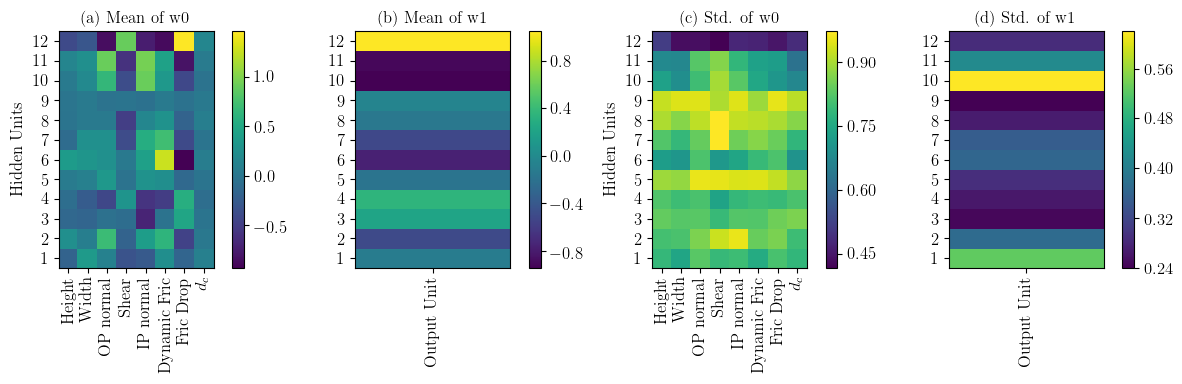

In [50]:
# %matplotlib notebook

plt.figure(figsize=(12, 4))

wgt = ['Mean of w0', 'Mean of w1', 'Std. of w0', 'Std. of w1']
lbl = ['a', 'b', 'c', 'd']

k = 0
for i in range(2):
    if i == 0:
        weights = post_weights_mean
    else:
        weights = post_weights_std
        
    plt.subplot(1,4, k + i + 1)
    aa = np.transpose(weights[0])
    plt.pcolormesh(aa, cmap = 'viridis', vmin = np.min(weights[0]), vmax = np.amax(weights[0]))
    labels = ['Height', 'Width', 'OP normal', 'Shear', 'IP normal', 'Dynamic Fric', 'Fric Drop', '$d_c$']

    plt.xticks([0.5+float(x) for x in range(0,8)], labels, rotation='vertical')
    plt.yticks([0.5+float(x) for x in range(0,12)], list(range(1,13)))
    plt.ylabel('Hidden Units')
    plt.title('('+ lbl[k + i] + ') ' + wgt[k + i])

    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.35)

    cb = plt.colorbar(orientation="vertical",fraction=0.07, pad=0.1)
    tick_locator = ticker.MaxNLocator(nbins=5)
    cb.locator = tick_locator
    cb.update_ticks()

    # Layer two plot
    plt.subplot(1, 4, k+i+2)
    bb = np.reshape(weights[1], (12, 1))
    plt.pcolormesh(bb, cmap = 'viridis', vmin = np.min(weights[1]), vmax = np.amax(weights[1]))
    plt.xticks([0.5],['Output Unit'],rotation='vertical')
    plt.yticks([0.5+float(x) for x in range(0,12)], list(range(1,13)))
    plt.title('('+ lbl[k+i+1] + ') ' + wgt[k+i+1])

    cb = plt.colorbar(orientation="vertical",fraction=0.07, pad=0.1)
    tick_locator = ticker.MaxNLocator(nbins=5)
    cb.locator = tick_locator
    cb.update_ticks()
    k = 1

plt.tight_layout()
plt.savefig('../paper/figures/network_uncertainity.eps')
plt.show()

### Evaluation

In [51]:
###
results = pd.DataFrame()
results['target'] = list(ytest)
results.target = results.target.apply(lambda x: int(x[0]))

In [52]:
results['predictions'] = predictions_samp.mean(axis = 0)
results['predStd'] = predictions_samp.std(axis = 0)
results['predVar'] = predictions_samp.var(axis = 0)

In [53]:
zzz = stats.norm.interval(0.95, loc = results['predictions'], scale = results['predStd'])
results['confidenceLow'] = np.transpose(zzz)[:, 0]
results['confidenceHigh'] = np.transpose(zzz)[:, 1]
results['confidenceRange'] = np.absolute(results['confidenceHigh'] - results['confidenceLow'])

In [54]:
df_test.label.value_counts()

0.0    272
1.0    128
Name: label, dtype: int64

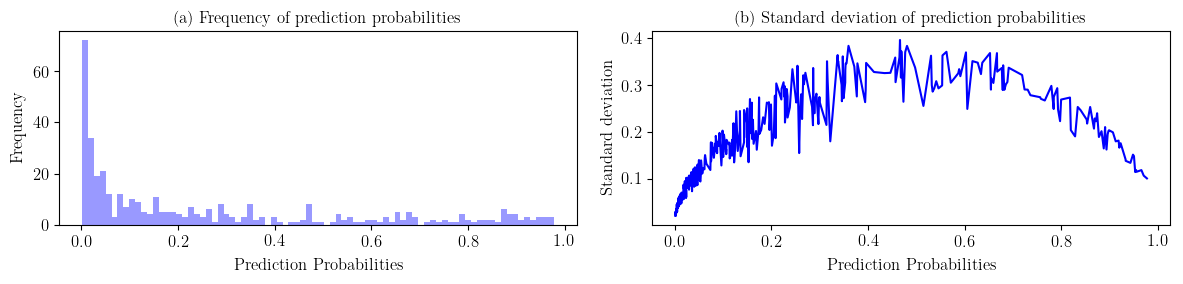

In [56]:
plt.figure(figsize=(12, 3))
plt.subplot(121)
sns.distplot(results.predictions, kde = False, bins = 80, color = 'blue')
plt.xlabel('Prediction Probabilities')
plt.title('(a) Frequency of prediction probabilities')
plt.ylabel('Frequency')

plt.subplot(122)
sns.lineplot(x = "predictions", y = "predStd", data = results, color = 'blue')
plt.xlabel('Prediction Probabilities')
plt.title('(b) Standard deviation of prediction probabilities')
plt.ylabel('Standard deviation')
plt.tight_layout()
plt.savefig('../paper/figures/uncertainity_statistics.eps')
# plt.show()

In [57]:
fpr, tpr, thresholds = metrics.roc_curve(ytest, results.predictions, pos_label=1)
p = figure(plot_width=600, plot_height=400, tools = TOOLS, x_axis_label = 'False positive rate', y_axis_label = 'True positive rate', title = 'ROC-AUC score: {}'.format(roc_auc_score(ytest, results.predictions)))
p.line(x = fpr, y = tpr, line_width=2, color = 'blue')
p.line(x = tpr, y = thresholds, line_width = 2, color = 'red')
show(p)

NameError: name 'figure' is not defined

In [58]:
def get_optimal_threshold():  
    thresholds = list(np.linspace(0, 1, 400))
    f1_scores = []
    for threshold in thresholds:
        ypred = results.predictions.apply(lambda x: 1 if x >= threshold else 0)
        f1_scores.append(f1_score(ytest, ypred, average = 'weighted'))

    return f1_scores, thresholds

In [59]:
f1_scores, th = get_optimal_threshold()

In [60]:
print(np.round(np.max(f1_scores)*100, 2), th[np.argmax(f1_scores)])

82.34 0.2882205513784461


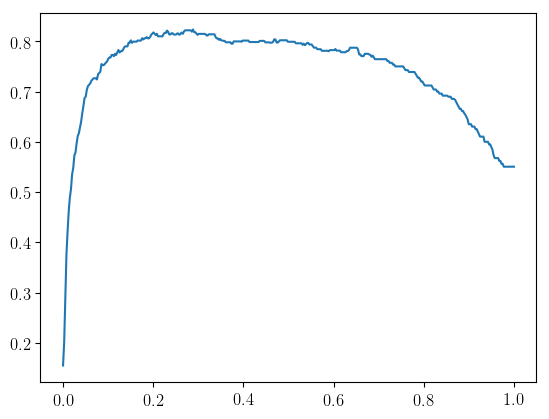

In [61]:
plt.plot(th, f1_scores)
plt.show()

In [62]:
threshold = th[np.argmax(f1_scores)]
results['binPred'] = results.predictions.apply(lambda x: 1 if x >= threshold else 0)

def prediction(ytest, ypred):
    print('Accuracy of the model: {}\n'.format(accuracy_score(ytest, ypred)))
    print('F1-score of the model: {}\n'.format(f1_score(ytest, ypred, average='weighted')))
    print('Classification report: \n{}\n'.format(classification_report(ytest, ypred)))
    print('Confusion matrix: \n{}\n'.format(confusion_matrix(ytest, ypred)))

prediction(ytest, results['binPred'])

Accuracy of the model: 0.8225

F1-score of the model: 0.8233769077118831

Classification report: 
             precision    recall  f1-score   support

        0.0       0.88      0.86      0.87       272
        1.0       0.71      0.74      0.73       128

avg / total       0.82      0.82      0.82       400


Confusion matrix: 
[[234  38]
 [ 33  95]]



### Prediction on the 

In [55]:
all_samples = pd.DataFrame(predictions_samp).applymap(lambda x: 1 if x >= threshold else 0)

In [56]:
results.head()

,target,predictions,predStd,predVar,confidenceLow,confidenceHigh,confidenceRange,binPred
0,0,0.223885,0.165206,0.027293,-0.099912,0.547683,0.647595,0
1,1,0.907516,0.102114,0.010427,0.707377,1.107656,0.400280,1
2,0,0.122942,0.167830,0.028167,-0.206000,0.451884,0.657883,0
3,0,0.214917,0.214297,0.045923,-0.205097,0.634932,0.840029,0
4,1,0.627130,0.284610,0.081003,0.069306,1.184955,1.115650,1


In [57]:
accuracies = []
for i in range(n_samples):
    ypred = all_samples.iloc[i]
    accuracies.append(f1_score(ytest, ypred, average='weighted'))

/Users/sabber/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


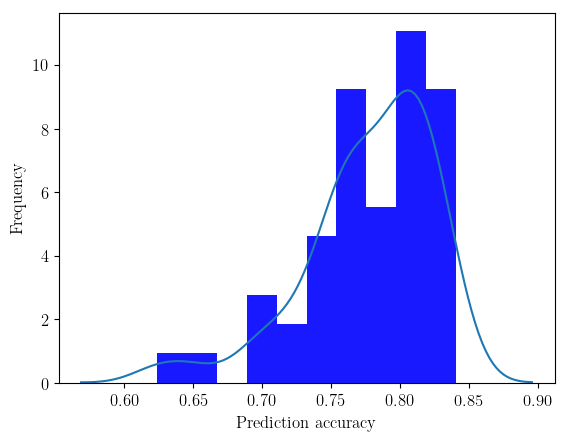

In [58]:
percent = [1]

for i in range(len(percent)):
    smapled_acc = np.random.choice(accuracies, size = int((percent[i]*n_samples)/100), replace = False)
    sns.distplot(smapled_acc, bins = 10, hist_kws={"linewidth":3, "alpha": 0.9, "color": "b"})
    plt.ylabel('Frequency')
    plt.xlabel('Prediction accuracy')
plt.show()

In [59]:
print(np.std(accuracies)*2, np.mean(accuracies), np.max(accuracies))

0.09394813876380356 0.779503962199302 0.860822384290133


### Error analysis

In [60]:
correct = results[(results.target == results.binPred)]
incorrect = results[(results.target != results.binPred)]

In [61]:
incorrect.confidenceRange[(incorrect.binPred == 0)].mean(axis = 0)

0.7881151090981965

In [62]:
correct.confidenceRange[(correct.binPred == 0)].mean(axis = 0)

0.6388338704004006

In [63]:
def plot_distribution(i):
    xxx = samplepredictions[:, i, 0]
    ax = sns.distplot(xxx, kde = False, fit=stats.gamma)
    ax2 = ax.twinx()
    sns.boxplot(x=xxx, ax=ax2)
    ax2.set(ylim=(-.5, 10))
    plt.show()

Actual: 0.0, Prediction: 0.0, pred_proba: 0.20238441228866577, std: 0.1748792827129364


/Users/sabber/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


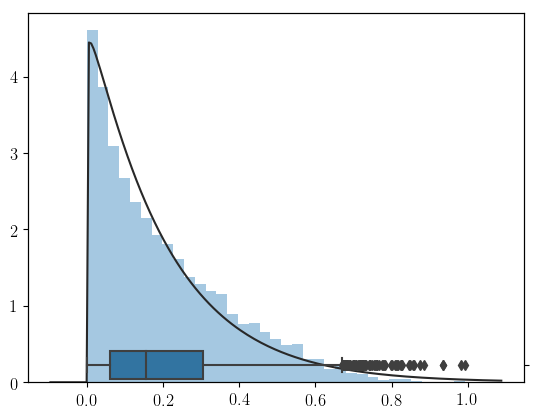

In [64]:
example = 200
print('Actual: {}, Prediction: {}, pred_proba: {}, std: {}'.format(results.iloc[example].target, 
                                                                   results.iloc[example].binPred,
                                                                   results.iloc[example].predictions,
                                                                   results.iloc[example].predStd))
plot_distribution(example)

### Result vizualisation

In [65]:
pca = PCA(n_components = 2, random_state = 2018).fit_transform(xtest)

results['pca_x1'] = pca[:, 0]
results['pca_x2'] = pca[:, 1]

In [66]:
results.head()

,target,predictions,predStd,predVar,confidenceLow,confidenceHigh,confidenceRange,binPred,pca_x1,pca_x2
0,0,0.223885,0.165206,0.027293,-0.099912,0.547683,0.647595,0,0.557490,-1.138433
1,1,0.907516,0.102114,0.010427,0.707377,1.107656,0.400280,1,0.372588,2.210410
2,0,0.122942,0.167830,0.028167,-0.206000,0.451884,0.657883,0,-2.883425,-0.418066
3,0,0.214917,0.214297,0.045923,-0.205097,0.634932,0.840029,0,0.412756,-1.462043
4,1,0.627130,0.284610,0.081003,0.069306,1.184955,1.115650,1,2.860224,0.236508


In [67]:
results.shape

(400, 10)

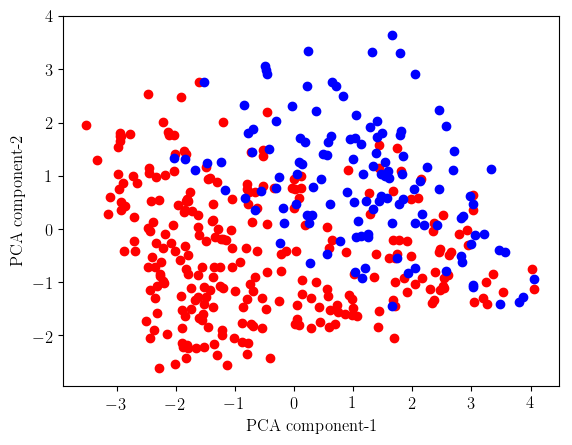

In [68]:
plt.scatter(results.pca_x1[results.target == 0], results.pca_x2[results.target == 0], color = 'r')
plt.scatter(results.pca_x1[results.target == 1], results.pca_x2[results.target == 1], color = 'b')

plt.xlabel('PCA component-1')
plt.ylabel('PCA component-2')
plt.show()

In [69]:
xi = np.linspace(-4, 4, 1000)
yi = np.linspace(-3, 4, 1000)
x, y = results.pca_x1, results.pca_x2

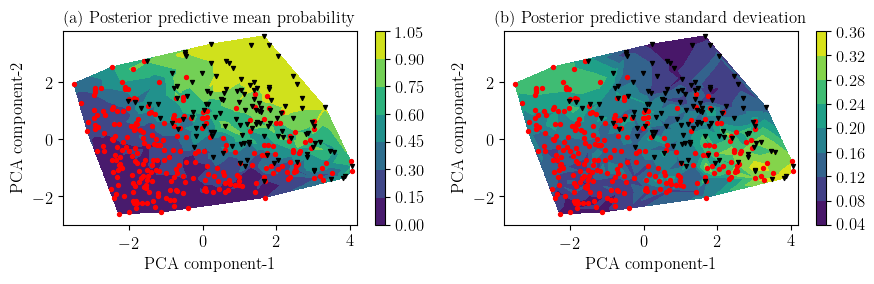

In [70]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(9, 3))
cmap = 'viridis'
axes = [ax1, ax2]
titles = ['(a) Posterior predictive mean probability', '(b) Posterior predictive standard devieation']
datas = [results.predictions, results.predStd]

for ax, data, title in zip(axes, datas, titles):
    zi = griddata(x, y, data, xi, yi, interp = 'linear')
#     ax.contour(xi, yi, zi, levels = 14, linewidths = 0.5, colors = 'k')
    contour = ax.contourf(xi, yi, zi, cmap = cmap)
    ax.scatter(results.pca_x1[results.target == 0], results.pca_x2[results.target == 0], color = 'r', s = 8, marker = 'o')
    ax.scatter(results.pca_x1[results.target == 1], results.pca_x2[results.target == 1], color = 'k', s = 8, marker = 'v')
    ax.set_title(title)
    cbar = plt.colorbar(contour, ax = ax)
    _ = ax.set(xlim = (-3.8, 4.2), ylim = (-3, 3.8), xlabel = 'PCA component-1', ylabel = 'PCA component-2')
fig.tight_layout()
fig.savefig('../paper/figures/posterior_proba_uncertainity.eps')

In [75]:
err = results[results.target != results.binPred]

In [76]:
corr = results[results.target == results.binPred]

In [77]:
err.describe()

,target,predictions,predStd,predVar,confidenceLow,confidenceHigh,confidenceRange,binPred,pca_x1,pca_x2
count,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000
mean,0.353846,0.587896,0.209595,0.046625,0.177097,0.998694,0.821597,0.646154,0.792576,0.452220
std,0.481883,0.163257,0.052321,0.022898,0.203552,0.181394,0.205094,0.481883,1.610943,0.952595
min,0.000000,0.264500,0.092852,0.008622,-0.200679,0.683248,0.363974,0.000000,-2.469655,-1.448623
25%,0.000000,0.467529,0.178958,0.032026,0.022057,0.862394,0.701501,0.000000,-0.532871,-0.268792
50%,0.000000,0.573222,0.201103,0.040442,0.162265,1.026559,0.788310,1.000000,1.048860,0.464139
75%,1.000000,0.707742,0.238829,0.057040,0.304527,1.160159,0.936194,1.000000,1.984933,1.086981
max,1.000000,0.946649,0.344251,0.118508,0.747890,1.315024,1.349437,1.000000,4.026778,2.756970


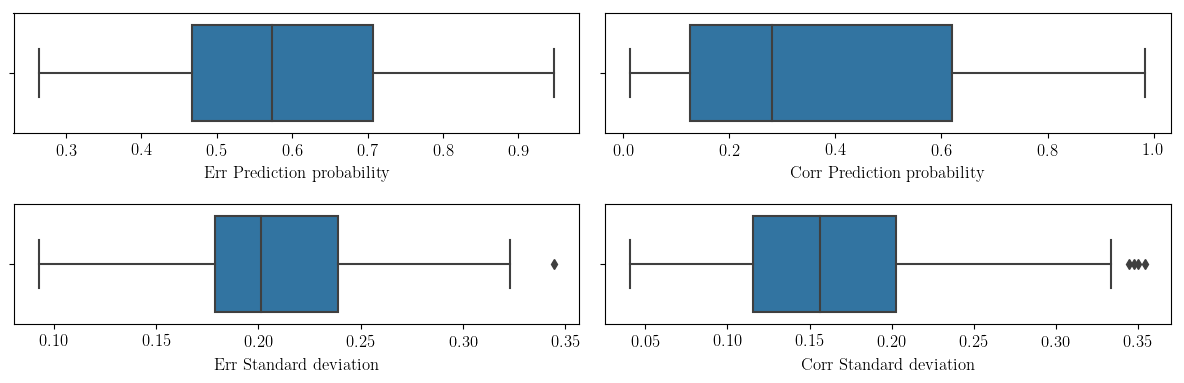

In [78]:
plt.figure(figsize=(12,4))
plt.subplot(221)
sns.boxplot(x = err.predictions, y = None)
plt.xlabel('Err Prediction probability')

plt.subplot(222)
sns.boxplot(x = corr.predictions, y = None)
plt.xlabel('Corr Prediction probability')

plt.subplot(223)
sns.boxplot(x = err.predStd, y = None)
plt.xlabel('Err Standard deviation')

plt.subplot(224)
sns.boxplot(x = corr.predStd, y = None)
plt.xlabel('Corr Standard deviation')
plt.tight_layout()

In [79]:
# err.head(80)

In [80]:
aa = np.reshape(xtest[3], (8,1)) * post_weights_mean[0]
bb = aa.sum(axis = 0)
z1 = np.reshape(bb * (bb > 0), (12, 1))
out = np.sum(z1 * np.reshape(post_weights_mean[2], (12, 1)), axis = 0)
prob = 1 / (1 + math.exp(-out))
print(prob)

0.004084768406285076


In [81]:
results.head()

,target,predictions,predStd,predVar,confidenceLow,confidenceHigh,confidenceRange,binPred,pca_x1,pca_x2
0,0,0.223885,0.165206,0.027293,-0.099912,0.547683,0.647595,0,0.557490,-1.138433
1,1,0.907516,0.102114,0.010427,0.707377,1.107656,0.400280,1,0.372588,2.210410
2,0,0.122942,0.167830,0.028167,-0.206000,0.451884,0.657883,0,-2.883425,-0.418066
3,0,0.214917,0.214297,0.045923,-0.205097,0.634932,0.840029,0,0.412756,-1.462043
4,1,0.627130,0.284610,0.081003,0.069306,1.184955,1.115650,1,2.860224,0.236508


### Network Uncertainity

In [82]:
# plt.figure(figsize= (12, 3))
# plt.subplot(151)
# plt.pcolormesh(post_weights_mean[0])

# plt.subplot(152)
# plt.pcolormesh(post_weights_mean[1])

# plt.subplot(143)
# plt.pcolormesh(post_weights_mean[1])

# plt.subplot(144)
# plt.pcolormesh(post_weights_mean[3])

In [83]:
# np.multiply(post_weights_mean[0], (xtest[0]))

### CRITICISM

In [84]:
results.head()

,target,predictions,predStd,predVar,confidenceLow,confidenceHigh,confidenceRange,binPred,pca_x1,pca_x2
0,0,0.223885,0.165206,0.027293,-0.099912,0.547683,0.647595,0,0.557490,-1.138433
1,1,0.907516,0.102114,0.010427,0.707377,1.107656,0.400280,1,0.372588,2.210410
2,0,0.122942,0.167830,0.028167,-0.206000,0.451884,0.657883,0,-2.883425,-0.418066
3,0,0.214917,0.214297,0.045923,-0.205097,0.634932,0.840029,0,0.412756,-1.462043
4,1,0.627130,0.284610,0.081003,0.069306,1.184955,1.115650,1,2.860224,0.236508


In [87]:
# threshold = 0.50
# import sys

def considerUncertainity(threshold, std):
    
    if threshold > 0.5 and std > 0.20:
        return 0
#     if threshold < 0.5 and std > 0.20:
#         return 1
#     elif threshold > 0.5 and std < 0.20:
#         return 1
    elif threshold < 0.5:
        return 0
    
    elif threshold > 0.5:
        return 1

uncertainityBinPred = []

for i in range(400):
    (th, std) = results.iloc[i]['predictions'], results.iloc[i]['predStd']
    uncertainityBinPred.append(considerUncertainity(th.astype('float'), std.astype('float')))

In [88]:
prediction(ytest, uncertainityBinPred)

Accuracy of the model: 0.82

F1-score of the model: 0.810858934169279

Classification report: 
             precision    recall  f1-score   support

        0.0       0.82      0.93      0.88       272
        1.0       0.80      0.58      0.67       128

avg / total       0.82      0.82      0.81       400


Confusion matrix: 
[[254  18]
 [ 54  74]]



In [ ]:
import matplotlib.pyplot as plt

y = np.random.randn(20)
y_rep = np.random.randn(20, 20)

ed.ppc_density_plot(y, y_rep)
plt.show()

In [ ]:
def define_network(images, num_classes=10):
    
     mean = tf.get_variable('mean', [28 * 28, num_classes])
     stddev = tf.get_variable('stddev', [28 * 28, num_classes])
     prior = tfd.MultivariateNormalDiag(
     tf.zeros_like(mean), tf.ones_like(stddev))
     posterior = tfd.MultivariateNormalDiag(mean, tf.nn.softplus(stddev))
     bias = tf.get_variable('bias', [num_classes]) # Or Bayesian, too
     logit = tf.nn.relu(tf.matmul(posterior.sample(), images) + bias)
     return tfd.Categorical(logit), posterior, prior

In [ ]:
dist, posterior, prior = define_network(images)
elbo = (tf.reduce_mean(dist.log_prob(label)) -
 tf.reduce_mean(tfd.kl_divergence(posterior, prior))